In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("src/")

import utils
import datetime
from config import Configuration
from otero_precipitation import Model #Python version
try:
    from otero_precipitation_wrapper import Model as _Model #C++ version
except ImportError as e:
    print(e)
    pass

In [2]:
def myConf():
    h = 10.
    location = 'cordoba'

    configuration = Configuration('resources/1c.cfg')
    configuration.config_parser.set('location','name',location)
    configuration.config_parser.set('simulation','start_date','2023-01-01')
    configuration.config_parser.set('simulation','end_date','2024-05-17')
    configuration.config_parser.set('breeding_site','height',str(h))
    configuration.config_parser.set('breeding_site','amount','1')

    configuration.save('myConf.cfg')
    return configuration


In [3]:
configuration = myConf()

model = Model(configuration)
t1 = time.time()
time_range, results = model.solveEquations()
t2 = time.time()
print('Elapsed time: ', t2-t1)

Elapsed time:  5.920722246170044


In [4]:
indexOf=lambda t: (np.abs(time_range-t)).argmin()

start_datetime = datetime.datetime.strptime(configuration.getString('simulation','start_date'),'%Y-%m-%d')
end_datetime = datetime.datetime.strptime(configuration.getString('simulation','end_date'),'%Y-%m-%d')
dates = [(start_datetime + datetime.timedelta(days=t)) for t in time_range]

parameters = model.parameters

EGG    = parameters.EGG
LARVAE = parameters.LARVAE
PUPAE  = parameters.PUPAE
ADULT1 = parameters.ADULT1
ADULT2 = parameters.ADULT2
WATER  = parameters.WATER
OVIPOSITION = parameters.OVIPOSITION
BS_a   = parameters.BS_a

E = np.sum(results[:,EGG],axis=1)/BS_a
L = np.sum(results[:,LARVAE],axis=1)/BS_a
A = (results[:,ADULT1]+results[:,ADULT2])/BS_a

lwO = np.array([results[indexOf(t),OVIPOSITION] - results[indexOf(t-7),OVIPOSITION] for t in time_range])
lwO_mean = np.array([lwO[indexOf(t-7):indexOf(t+7)].mean(axis=0) for t in time_range])
O = np.sum(lwO_mean,axis=1)/BS_a

T      = parameters.weather.T
RH     = parameters.weather.RH

location = parameters.location['name']

T = T(time_range) - 273.15
P = utils.getPrecipitationsFromCsv(f'data/public/{location}.csv',start_datetime.date(),end_datetime.date())
RH = RH(time_range)

df = pd.DataFrame({'date':dates,'E':E,'L':L,'A':A,'O':O,'p':P,'T':T,'RH':RH})
df.set_index('date',inplace=True)
df.to_csv('results.csv',index=True)

In [5]:
model = _Model('myConf.cfg')
t1 = time.time()
time_range, results = model.solveEquations()
t2 = time.time()
print('Elapsed time: ', t2-t1)

results = np.array(results)
time_range = np.array(time_range)

Elapsed time:  0.08661031723022461


In [6]:
indexOf=lambda t: (np.abs(time_range-t)).argmin()

start_datetime = datetime.datetime.strptime(configuration.getString('simulation','start_date'),'%Y-%m-%d')
end_datetime = datetime.datetime.strptime(configuration.getString('simulation','end_date'),'%Y-%m-%d')
dates = [(start_datetime + datetime.timedelta(days=t)) for t in time_range]

parameters = model.parameters

EGG    = slice(parameters.EGG.first(), parameters.EGG.first() + parameters.EGG.size()) 
LARVAE = slice(parameters.LARVAE.first(), parameters.LARVAE.first() + parameters.LARVAE.size())
PUPAE  = slice(parameters.PUPAE.first(), parameters.PUPAE.first() + parameters.PUPAE.size())
ADULT1 = parameters.ADULT1
ADULT2 = parameters.ADULT2
WATER  = slice(parameters.WATER.first(), parameters.WATER.first() + parameters.WATER.size())
OVIPOSITION = slice(parameters.OVIPOSITION.first(), parameters.OVIPOSITION.first() + parameters.OVIPOSITION.size())
BS_a   = parameters.BS_a

E = np.sum(results[:,EGG],axis=1)/BS_a
L = np.sum(results[:,LARVAE],axis=1)/BS_a
A = (results[:,ADULT1]+results[:,ADULT2])/BS_a

lwO = np.array([results[indexOf(t),OVIPOSITION] - results[indexOf(t-7),OVIPOSITION] for t in time_range])
lwO_mean = np.array([lwO[indexOf(t-7):indexOf(t+7)].mean(axis=0) for t in time_range])
O = np.sum(lwO_mean,axis=1)/BS_a

T      = parameters.weather.T
RH     = parameters.weather.RH

location = parameters.location

T = np.array([T(t) - 273.15 for t in time_range])
P = utils.getPrecipitationsFromCsv(f'data/public/{location}.csv',start_datetime.date(),end_datetime.date())
RH = np.array([RH(t) - 273.15 for t in time_range])

df1 = pd.DataFrame({'date':dates,'E':E,'L':L,'A':A,'O':O,'p':P,'T':T,'RH':RH})
df1.set_index('date',inplace=True)
df1.to_csv('results_cpp.csv',index=True)

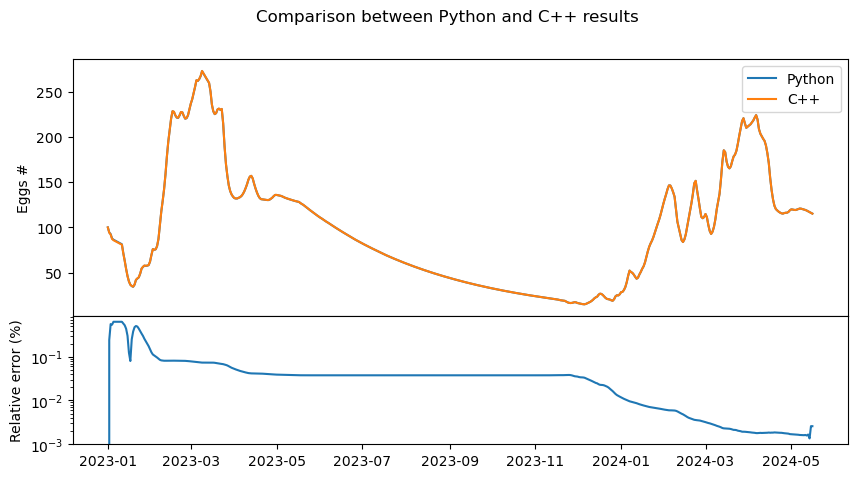

In [7]:
fig, axs = plt.subplots(2,1,height_ratios=[2,1],figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs[0].plot(df.index,df.E,label='Python')
axs[0].plot(df1.index,df1.E,label='C++')
axs[0].legend()
axs[0].set_ylabel('Eggs #')

axs[1].plot(df.index,np.abs((df.E - df1.E)/df1.E)*100)
axs[1].semilogy();
axs[1].set_ylabel('Relative error (%)');

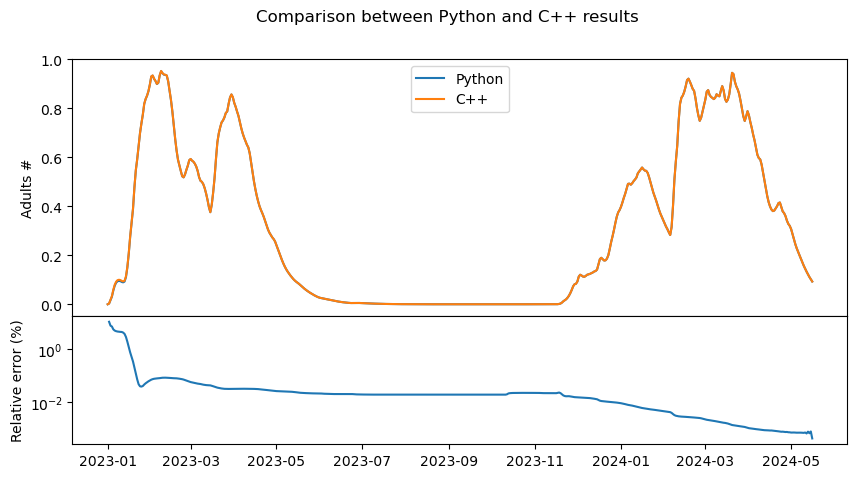

In [8]:
fig, axs = plt.subplots(2,1,height_ratios=[2,1],figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs[0].plot(df.index,df.A,label='Python')
axs[0].plot(df1.index,df1.A,label='C++')
axs[0].legend()
axs[0].set_ylabel('Adults #')

axs[1].plot(df.index,np.abs((df.A - df1.A)/df1.A)*100)
axs[1].semilogy();
axs[1].set_ylabel('Relative error (%)');

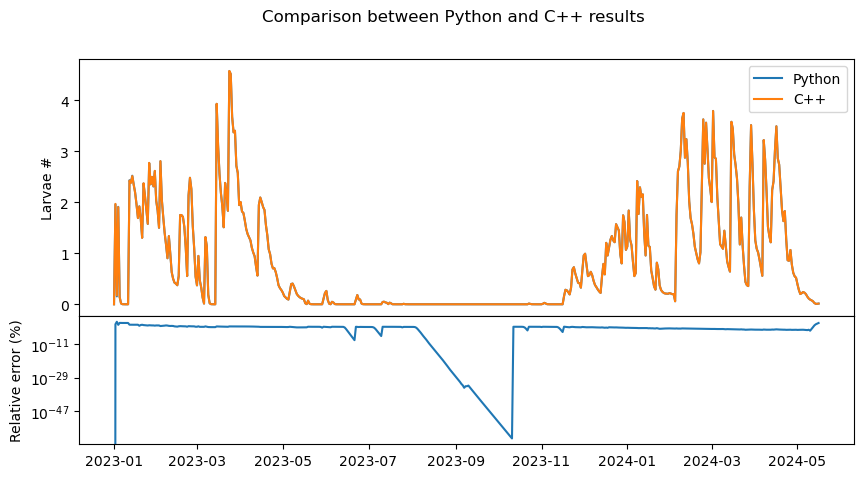

In [9]:
fig, axs = plt.subplots(2,1,height_ratios=[2,1],figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs[0].plot(df.index,df.L,label='Python')
axs[0].plot(df1.index,df1.L,label='C++')
axs[0].legend()
axs[0].set_ylabel('Larvae #')

axs[1].plot(df.index,np.abs((df.L - df1.L)/(df1.L+1.e-10))*100)
axs[1].semilogy();
axs[1].set_ylabel('Relative error (%)');